In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams
from sklearn import preprocessing, metrics
import tensorflow as tf
rcParams['figure.figsize'] = 12, 8

In [45]:
df = pd.read_csv('OnlineNewsPopularity.csv').sample(frac=1)
df.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,...,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,...,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,...,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,339.000000,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000
75%,542.000000,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,2800.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


In [46]:
features = df.columns[df.dtypes == np.float64]
target = ' shares'
X = preprocessing.MinMaxScaler().fit_transform(df[features])
Y = np.log(df[target])

N = X.shape[0]

split = np.round(np.array([0.7, 0.85]) * N).astype(np.int)
X_t, X_cv, X_test = np.array_split(X, split)
Y_t, Y_cv, Y_test = np.array_split(Y.reshape(-1, 1), split)

In [53]:
from tflearn.layers.core import input_data, fully_connected
from tflearn.activations import relu6
from tflearn.layers.normalization import batch_normalization as BN
import tflearn

batch_size = 64

with tf.Graph().as_default():
    X = tf.placeholder(tf.float32, (None, X_t.shape[1]))
    Y = tf.placeholder(tf.float32, (None, 1))
    
    network = X
    for x in [10, 5]:
        network = relu6(BN(fully_connected(
                    network, x, regularizer='L2', weight_decay=0
                )))
    network = fully_connected(network, 1)
        
    loss = tf.reduce_mean(tf.squared_difference(Y, network)) \
        + sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
    
    
    global_step = tf.Variable(1, dtype=tf.float32, trainable=False)
    learning_rate = tf.mul(1e-2, tf.rsqrt(global_step))
    optimizer = tf.train.AdamOptimizer(learning_rate)\
        .minimize(loss, global_step=global_step)
    
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        def training():
            step = 1
            for epoh in range(1,101):
                perm = np.random.permutation(X_t.shape[0])
                for batch_idx in np.array_split(perm, len(perm)/batch_size):
                    tflearn.is_training(True)

                    sess.run(optimizer, feed_dict = {
                            X: X_t[batch_idx],
                            Y: Y_t[batch_idx]
                        })
                    tflearn.is_training(False)

                    if step % 100 == 0:
                        sample = np.random.randint(X_t.shape[0], size=[1000])

                        score_t = 0.5 * metrics.mean_squared_error(
                            sess.run(network, feed_dict={
                                    X:X_t[sample]}),
                                    Y_t[sample])

                        y_ctp =  sess.run(network, feed_dict={X:X_cv})
                        score_cv = 0.5 * metrics.mean_squared_error(y_ctp, Y_cv)
                        print ("[%5d] %15.10f %15.10f" % (step, score_t, score_cv))
                        if score_cv < 0.372: # Close minumum found empirically for early stopping
                            y_tp = sess.run(network, feed_dict={X:X_test})
                            return
                            
                    step += 1
        training()

[  100]   22.3847563078   22.4082604534
[  200]   18.8966747785   18.9865819464
[  300]   15.7829350061   16.1191516598
[  400]   13.7996363122   13.8010605462
[  500]   11.7649000402   11.6712330166
[  600]   10.0233792534   10.0332011419
[  700]    8.3459123874    8.4944163455
[  800]    6.9497290262    7.0749181766
[  900]    6.1093877210    6.0754971878
[ 1000]    5.2027188493    5.0286305214
[ 1100]    4.1073333028    4.2241738770
[ 1200]    3.4352648023    3.5490005516
[ 1300]    2.8636950069    2.9907818894
[ 1400]    2.4321619452    2.4620610788
[ 1500]    2.0333025152    2.0698356104
[ 1600]    1.8879638020    1.8126414608
[ 1700]    1.5502845563    1.4651673944
[ 1800]    1.2903563907    1.2518734261
[ 1900]    1.0616750429    1.0650007521
[ 2000]    0.8771261143    0.8781740230
[ 2100]    0.7557429019    0.7911237321
[ 2200]    0.7316704250    0.7042712009
[ 2300]    0.6377886665    0.6394016601
[ 2400]    0.5994244607    0.5830020027
[ 2500]    0.5176142895    0.5377896012


In [33]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor().fit(X_t, Y_t)

In [40]:
df_knn = pd.DataFrame([{
        "predictor":"k-NN", 
        "error" : x[0] 
    } for x in (model.predict(X_test) - Y_test)/np.log(10)])

df_knn.describe()

,error
count,5947.000000
mean,-0.012123
std,0.412063
min,-2.290949
25%,-0.199731
50%,0.039856
75%,0.241763
max,2.683309


In [56]:
df_nn = pd.DataFrame([{
        "predictor":"NN", 
        "error" : x[0] 
    } for x in (y_tp - Y_test)/np.log(10)])
df_nn.describe()

,error
count,5947.000000
mean,0.051074
std,0.446893
min,-2.116716
25%,-0.174870
50%,0.116867
75%,0.355798
max,3.210119


In [57]:
df = pd.concat([df_knn, df_nn])

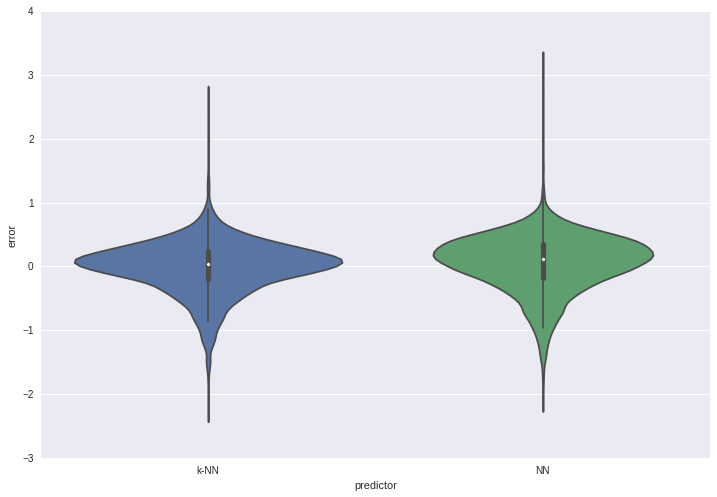

In [58]:
sns.violinplot(x='predictor', y='error', data=df)

In [59]:
df.groupby(["predictor"]).mean()

,error
predictor,
NN,0.051074
k-NN,-0.012123


In [60]:
df.groupby(["predictor"]).std()

,error
predictor,
NN,0.446893
k-NN,0.412063
